In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial

import sys

sys.path.append("..")

import tetrahedron
import proj_quality

%load_ext autoreload
%autoreload 2

In [2]:
from metric.metric import Metric, Euclid

In [3]:
def max_dist_points(ps):
    ps = points
    dists = spatial.distance_matrix(ps, ps)
    flat_index = dists.argmax()
    row_index, col_index = np.unravel_index(flat_index, dists.shape)
    return ps[row_index], ps[col_index]

In [4]:
from tqdm import tqdm


def best_pivot_partner(p1):
    for p0 in tqdm(points):
        if all(p0 == p1):
            yield np.inf
            continue
        proj = tetrahedron.project_to_2d_euclidean(points, p0, p1, dist_func)
        yield proj_quality.candidate_set_size(proj, ten_nn_dist, Euclid(2))

In [8]:
# simulate triangles
rng = np.random.default_rng()

dist_func = lambda x, y: spatial.minkowski_distance(
    x, y, 2
)  # np.linalg.norm(x-y, axis=-1)
n_samples = 500
dim = 5
points = rng.integers(-37, 38, size=[n_samples, dim])
# p0,p1,q,o = 0,1,2,3

ten_nn_dist = proj_quality.get_average_k_nn_dist(points, Euclid(2))

# p0, p1 = np.array([-30]*dim).T, np.array([30]*dim).T
p0, p1 = points[0], points[1]
points_p = tetrahedron.project_to_2d_euclidean(points, p0, p1, dist_func)

In [9]:
p_m0, p_m1 = max_dist_points(points)
points_p_max_dist = tetrahedron.project_to_2d_euclidean(points, p_m0, p_m1, dist_func)

100%|████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 76.95it/s]


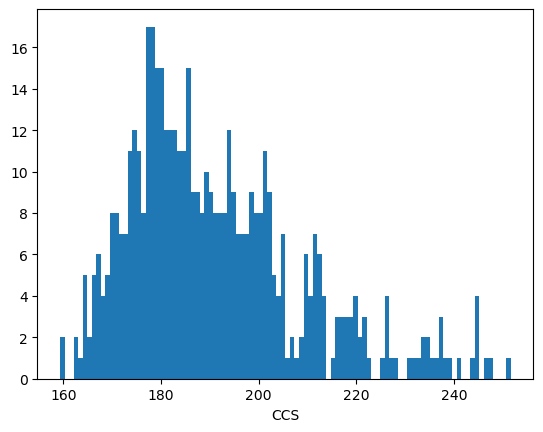

In [10]:
# optimize one criteron
partner_rho = np.array(list(best_pivot_partner(p_m0)))
plt.hist(partner_rho[~np.isinf(partner_rho)], bins=100)
plt.xlabel("CCS")
plt.show()

partner_idx = np.argsort(partner_rho)[0]
p_m1 = points[partner_idx]

points_p_good_css = tetrahedron.project_to_2d_euclidean(points, p_m0, p_m1, dist_func)

100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 126.36it/s]


ValueError: supplied range of [159.316, inf] is not finite

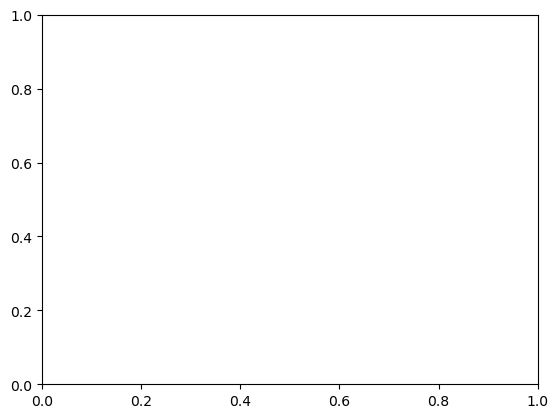

In [12]:
# optimize the other criteron
def _hilbert_quality(pivot):
    try:
        ps = tetrahedron.project_to_2d_euclidean(points, p_m0, pivot, dist_func)
        part = proj_quality.HilbertPartitioner(ps, ten_nn_dist)
        return part.hyperplane_quality(ps)
    except KeyError:
        return 0


partner_hq = [_hilbert_quality(piv) for piv in tqdm(points)]
plt.hist(partner_rho, bins=100)
plt.show()

best_piv_idx = np.argmax(partner_rho)
p_m1 = points[best_piv_idx]

points_p_good_hq = tetrahedron.project_to_2d_euclidean(points, p_m0, p_m1, dist_func)

In [13]:
def calc_scale(points, dist_func, knn=10):
    """Calculate the average knn distance"""
    SAMPLE_SIZE = 100
    queries = rng.choice(points, size=SAMPLE_SIZE)
    k_range = [np.sort(dist_func(q, points))[knn] for q in queries]
    return np.mean(k_range)


def range_query(points, query_center, radius, dist_func, return_indices=False):
    """Return all points within the radius of query_center"""
    dist = dist_func(query_center, points)
    if return_indices:
        return np.nonzero(dist <= radius)[0]
    else:
        return points[dist <= radius]


def set_of_points(points):
    return list(map(tuple, points))

In [14]:
from scipy import stats


def rate_pivot_overhead(points_orig, points_piv, dist_func_orig, dist_func_piv):
    assert len(points_orig) == len(points_piv)

    mean_query_range = calc_scale(points_orig, dist_func_orig)
    # kde = stats.gaussian_kde(points_piv)

    SAMPLE_SIZE = 1000
    q_center_idx = rng.integers(0, len(points_orig), size=SAMPLE_SIZE)

    query_conf_piv = dict(
        points=points_piv,
        radius=mean_query_range,
        dist_func=dist_func_piv,
        return_indices=True,
    )
    candidates = [
        range_query(query_center=points_piv[q], **query_conf_piv) for q in q_center_idx
    ]

    query_conf_orig = dict(
        points=points_orig,
        radius=mean_query_range,
        dist_func=dist_func_orig,
        return_indices=True,
    )
    controls = [
        range_query(query_center=points_orig[q], **query_conf_orig)
        for q in q_center_idx
    ]

    # return candidates, controls
    assert all(
        [
            set(actual_set).issubset(set(candidate_set))
            for candidate_set, actual_set in zip(candidates, controls)
        ]
    ), (
        "The actual query solution must be a subsets of the candidate set from the pivot space!"
    )

    unnecessary_dist_evals = [
        len(candidate_set) - len(actual_set)
        for candidate_set, actual_set in zip(candidates, controls)
    ]
    return np.mean(unnecessary_dist_evals), np.std(unnecessary_dist_evals, ddof=1)


rate_pivot_efficency(points, points_p, dist_func, dist_func)

NameError: name 'rate_pivot_efficency' is not defined

In [15]:
# plot distance gauge
ten_nn_dist = proj_quality.get_average_k_nn_dist(points, Euclid(2))

In [16]:
def draw_circle(center, radius, **kwargs):
    # Create a circle with the specified radius
    circle = plt.Circle(center, radius, fill=False, edgecolor="blue", **kwargs)

    # Add the circle to the axes
    plt.gca().add_artist(circle)

NameError: name 'points_p_good' is not defined

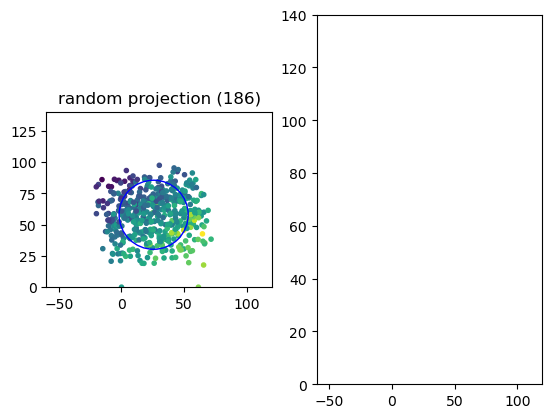

In [17]:
def set_lims():
    plt.xlim(-60, 120)
    plt.ylim(0, 140)


plt.subplot(1, 2, 1)
set_lims()

nans = np.isnan(points_p).sum(axis=1).astype("bool")
points_p = points_p[~nans, :]

c = points[~nans, :].sum(axis=1)

# closer_to_p0 = dist_func(points, p0) < dist_func(points, p1)
plt.scatter(*points_p.T, c=c, marker=".")


rho = proj_quality.candidate_set_size(points_p, ten_nn_dist, Euclid(2))
# plt.title(f"mean candidate set size: {rho:.0f}")
plt.title(f"random projection ({rho:.0f})")

center = np.array([points_p[:, 0].mean(), points_p[:, 1].mean()])

draw_circle(center, ten_nn_dist, label="average 10-NN distance")

# plt.legend()
plt.gca().set_aspect("equal")
plt.subplot(1, 2, 2)
set_lims()

nans = np.isnan(points_p_good).sum(axis=1).astype("bool")
points_p_good = points_p_good[~nans, :]

c = points[~nans, :].sum(axis=1)

# closer_to_p0 = dist_func(points, p0) < dist_func(points, p1)
plt.scatter(*points_p_good.T, c=c, marker=".")


rho = proj_quality.candidate_set_size(points_p_good, ten_nn_dist, Euclid(2))
# plt.title(f"mean candidate set size: {rho:.0f}")
plt.title(f"our projection ({rho:.0f})")

center = np.array([points_p_good[:, 0].mean(), points_p_good[:, 1].mean()])

draw_circle(center, ten_nn_dist, label="average 10-NN distance")

# plt.legend()
plt.gca().set_aspect("equal");

In [18]:
def plot_hilbert_qual(ps):
    part = proj_quality.HilbertPartitioner(ps, ten_nn_dist)
    l, r = part.get_partitions(ps)

    plt.scatter(*ps.T)
    plt.scatter(*ps[l].T, marker="+")
    plt.scatter(*ps[r].T, marker="x")

    hq = part.hyperplane_quality(ps)
    css = proj_quality.candidate_set_size(ps, ten_nn_dist, Euclid(2))
    plt.title(f"partitioning {hq:.0%} points\nmean CSS {css:.0f}")

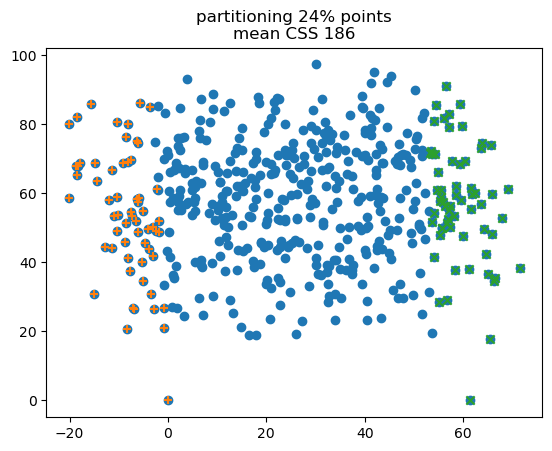

In [25]:
plot_hilbert_qual(points_p)

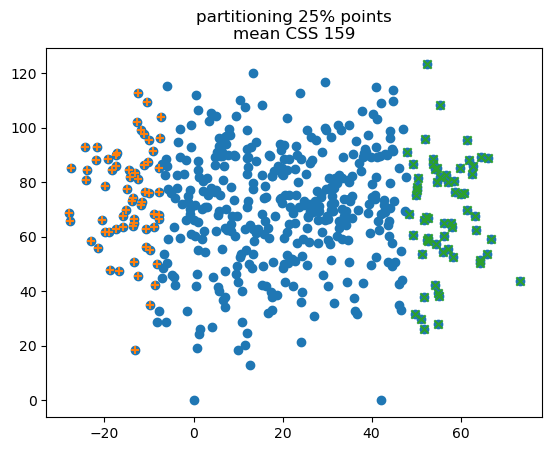

In [26]:
plot_hilbert_qual(points_p_good_css)

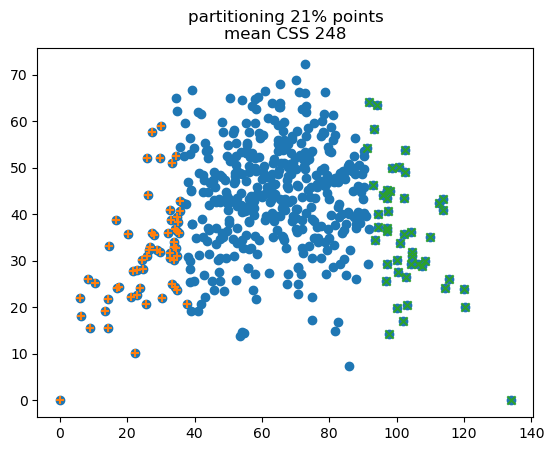

In [27]:
plot_hilbert_qual(points_p_max_dist)

In [22]:
plot_hilbert_qual(points_p_good_hq)

NameError: name 'points_p_good_hq' is not defined

In [23]:
partner_rho = list(best_pivot(points[0]))

NameError: name 'best_pivot' is not defined

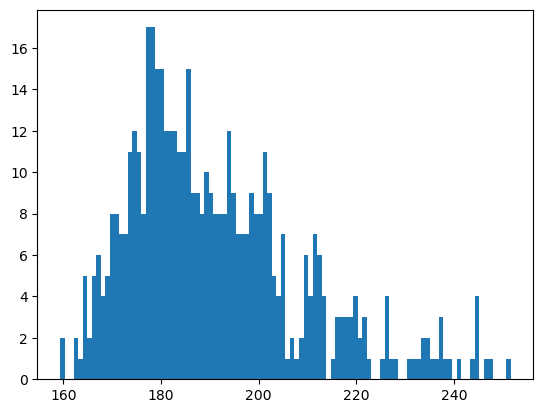

In [24]:
partner_rho = np.array(partner_rho)
plt.hist(partner_rho[~np.isinf(partner_rho)], bins=100);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 28.73it/s]


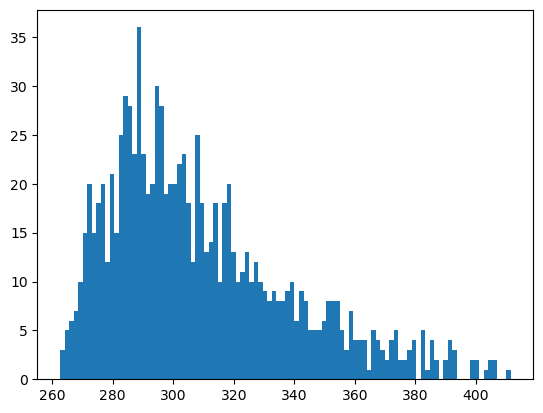

array([581, 306, 914,  61, 295, 556, 509, 175, 338, 219,  91, 391, 197,
       947, 912, 943,   1, 232, 180, 453, 443, 789, 991, 675, 564, 952,
       237,  17, 247, 778, 519, 820,  49, 125, 867, 436, 464, 824, 425,
        29,  84, 583, 513, 510, 421, 245, 674, 491, 599, 600, 679, 587,
       694, 277, 656,  78, 990, 776, 666, 935, 663, 892, 270, 307,  43,
       728, 619,  57, 518, 609, 771,  52,  40, 743, 712, 296, 240, 227,
       199, 695, 750, 686, 877, 110, 761, 953, 770, 399, 948, 209, 536,
       370, 498, 785, 511, 844, 794,  18, 143, 832, 218, 401, 601,  88,
        80, 432, 521, 774, 332, 725, 330,  10, 414, 324, 190,  60, 780,
       906, 375, 907, 650, 297, 715, 213, 178, 472, 563, 305, 797, 146,
       212, 242, 775, 526, 628, 933, 396, 144, 273, 745, 593, 470, 690,
        95, 272, 633, 186, 665, 456, 572, 157, 361, 898, 614,  69, 462,
        98, 435, 949, 302, 203, 946, 683, 515, 713, 535, 992, 131, 711,
       420, 390, 492, 787, 383, 353, 266, 423, 189, 940, 152, 54

In [ ]:
plt.plot(
    [points_p[:, 0].min(), points_p[:, 0].min() + ten_nn_dist],
    [points_p[:, 1].min(), points_p[:, 1].min() + ten_nn_dist],
    color="C1",
    label="average 10-NN distance",
)

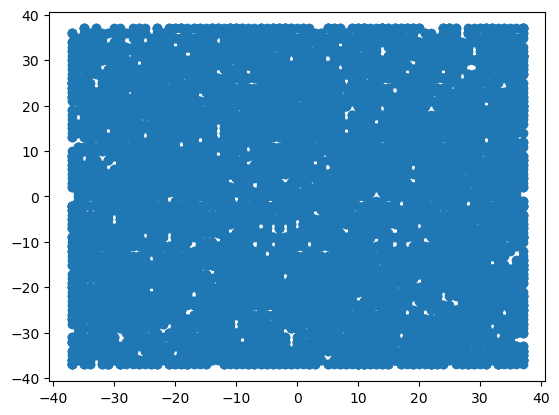

In [13]:
plt.scatter(*points.T[:2])

In [14]:
close_to_p1 = np.argsort(dist_func(p1, points))
next_pivs = points[close_to_p1]

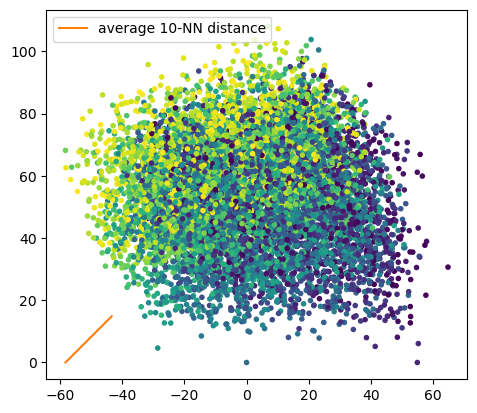

In [15]:
p1_new = next_pivs[-20]
points_p = tetrahedron.project_to_2d_euclidean(points, p0, p1_new, dist_func)

nans = np.isnan(points_p).sum(axis=1).astype("bool")
points_p = points_p[~nans, :]
c = points[~nans, 0]

# closer_to_p0 = dist_func(points, p0) < dist_func(points, p1)
plt.scatter(*points_p.T, c=c, marker=".")


# plot distance gauge
ten_nn_dist = np.sort(dist_func([0] * dim, points))[9]
plt.plot(
    [points_p[:, 0].min(), points_p[:, 0].min() + ten_nn_dist],
    [points_p[:, 1].min(), points_p[:, 1].min() + ten_nn_dist],
    color="C1",
    label="average 10-NN distance",
)

plt.legend()
plt.gca().set_aspect("equal");